In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import statistics as s

In [21]:
torch.manual_seed(1)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [22]:
def dataset_prep(batch_size):
    transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])
    train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=transform)

    training_DataLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    testing_DataLoader= DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return training_DataLoader, testing_DataLoader

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(784, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
import time

def train(model, optimizer, train_loader):
    model.train()
    loss_func = torch.nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0
    batch_loss = []

    start_time = time.time() 

    for i, batch in enumerate(train_loader):
        images, labels = batch[0].to(device), batch[1].to(device)
        
        output = model(images)
        loss = loss_func(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        batch_loss.append(loss.item())

    elapsed_time = time.time() - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds")

    train_loss = sum(batch_loss) / len(train_loader.dataset)
    accuracy = 100. * correct / total_samples

    return train_loss, accuracy

def test(model, test_loader):
    model.eval()
    test_losses = []
    loss_func = torch.nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0

    start_time = time.time() 

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            output = model(images)
            loss = loss_func(output, labels)
            test_losses.append(loss.item())

            _, pred = torch.max(output, 1)
            correct += (pred == labels).sum().item()
            total_samples += labels.size(0)

    elapsed_time = time.time() - start_time
    print(f"Testing completed in {elapsed_time:.2f} seconds")

    test_loss = sum(test_losses) / len(test_loader.dataset)
    accuracy = 100. * correct / total_samples

    return test_loss, accuracy

In [23]:
epochs = 24
train_loss_dict = {}
train_acc_dict = {}
test_loss_dict = {}
test_acc_dict = {}
model_state = {}

for batch_size in [64, 1024]:
    for lr in [1e-3, 1e-2]:
        training_DataLoader, testing_DataLoader = dataset_prep(batch_size)
        print(f"For Model with batch size {batch_size} and learning rate {lr}")
        
        model = Model().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loss_arr, train_acc_arr = [], []
        test_loss_arr, test_acc_arr = [], []

        for epoch in range(epochs):
            train_loss, train_acc = train(model, optimizer, training_DataLoader)
            test_loss, test_acc = test(model, testing_DataLoader)
            
            print(f"Epoch {epoch} | Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}, "
                  f"Train Accuracy: {train_acc:.6f}%, Test Accuracy: {test_acc:.6f}%")

            train_loss_arr.append(train_loss)
            train_acc_arr.append(train_acc)
            test_loss_arr.append(test_loss)
            test_acc_arr.append(test_acc)

        key_str = f"model_bs_{batch_size}_lr_{lr}"
        
        train_loss_dict[key_str] = train_loss_arr
        train_acc_dict[key_str] = train_acc_arr
        test_loss_dict[key_str] = test_loss_arr
        test_acc_dict[key_str] = test_acc_arr
        model_state[key_str] = model

For Model with batch size 64 and learning rate 0.001
Training completed in 11.57 seconds
Testing completed in 1.76 seconds
Epoch 0 | Train Loss: 0.006241, Test Loss: 0.003741, Train Accuracy: 88.346667%, Test Accuracy: 92.870000%
Training completed in 11.38 seconds
Testing completed in 1.74 seconds
Epoch 1 | Train Loss: 0.003192, Test Loss: 0.002841, Train Accuracy: 93.981667%, Test Accuracy: 94.620000%
Training completed in 11.40 seconds
Testing completed in 1.76 seconds
Epoch 2 | Train Loss: 0.002496, Test Loss: 0.002536, Train Accuracy: 95.231667%, Test Accuracy: 95.160000%
Training completed in 11.46 seconds
Testing completed in 1.76 seconds
Epoch 3 | Train Loss: 0.002128, Test Loss: 0.002327, Train Accuracy: 95.876667%, Test Accuracy: 95.770000%
Training completed in 11.41 seconds
Testing completed in 1.74 seconds
Epoch 4 | Train Loss: 0.001858, Test Loss: 0.002132, Train Accuracy: 96.440000%, Test Accuracy: 95.920000%
Training completed in 11.39 seconds
Testing completed in 1.74 

In [24]:
def analysis(model, dataset_loader):
    model.eval()
    losses = []
    loss_func = torch.nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataset_loader:
            images, labels = batch[0].to(device), batch[1].to(device)

            output = model(images)
            loss = loss_func(output, labels)
            losses.append(loss.item())

            _, predictions = torch.max(output, 1)
            correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = sum(losses) / len(dataset_loader.dataset)
    accuracy = 100. * correct / total_samples

    return avg_loss, accuracy

def interpolation(m1, m2, training_loader, testing_loader):
    train_loss_arr = []
    train_acc_arr = []
    test_loss_arr = []
    test_acc_arr = []
    alphas = np.linspace(-2, 2, 10)  

    for idx, alpha in enumerate(alphas):
        print(f"Interpolation step {idx} with alpha {alpha:.2f}")

        interpolated_params = {}
        for param_name, param_m1 in m1.named_parameters():
            param_m2 = m2.state_dict()[param_name]
            interpolated_params[param_name] = (1 - alpha) * param_m1 + alpha * param_m2

        interpolated_model = Model().to(device)
        interpolated_model.load_state_dict(interpolated_params)

        train_loss, train_acc = analysis(interpolated_model, training_loader)
        test_loss, test_acc = analysis(interpolated_model, testing_loader)

        train_loss_arr.append(train_loss)
        train_acc_arr.append(train_acc)
        test_loss_arr.append(test_loss)
        test_acc_arr.append(test_acc)

    return train_loss_arr, train_acc_arr, test_loss_arr, test_acc_arr

In [30]:
model_state

{'model_bs_64_lr_0.001': Model(
   (fc1): Linear(in_features=784, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=16, bias=True)
   (fc3): Linear(in_features=16, out_features=10, bias=True)
 ),
 'model_bs_64_lr_0.01': Model(
   (fc1): Linear(in_features=784, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=16, bias=True)
   (fc3): Linear(in_features=16, out_features=10, bias=True)
 ),
 'model_bs_1024_lr_0.001': Model(
   (fc1): Linear(in_features=784, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=16, bias=True)
   (fc3): Linear(in_features=16, out_features=10, bias=True)
 ),
 'model_bs_1024_lr_0.01': Model(
   (fc1): Linear(in_features=784, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=16, bias=True)
   (fc3): Linear(in_features=16, out_features=10, bias=True)
 )}

In [31]:
# Prepare data loaders with different batch sizes
train_loader_64, test_loader_64 = dataset_prep(64)
train_loader_1024, test_loader_1024 = dataset_prep(1024)

# Perform interpolation between models with learning rate 0.001 for different batch sizes
train_loss_arr, train_acc_arr, test_loss_arr, test_acc_arr = interpolation(
    model_state["model_bs_64_lr_0.001"],
    model_state["model_bs_1024_lr_0.001"],
    train_loader_1024, 
    test_loader_1024
)


Interpolation step 0 with alpha -2.00
Interpolation step 1 with alpha -1.56
Interpolation step 2 with alpha -1.11
Interpolation step 3 with alpha -0.67
Interpolation step 4 with alpha -0.22
Interpolation step 5 with alpha 0.22
Interpolation step 6 with alpha 0.67
Interpolation step 7 with alpha 1.11
Interpolation step 8 with alpha 1.56
Interpolation step 9 with alpha 2.00


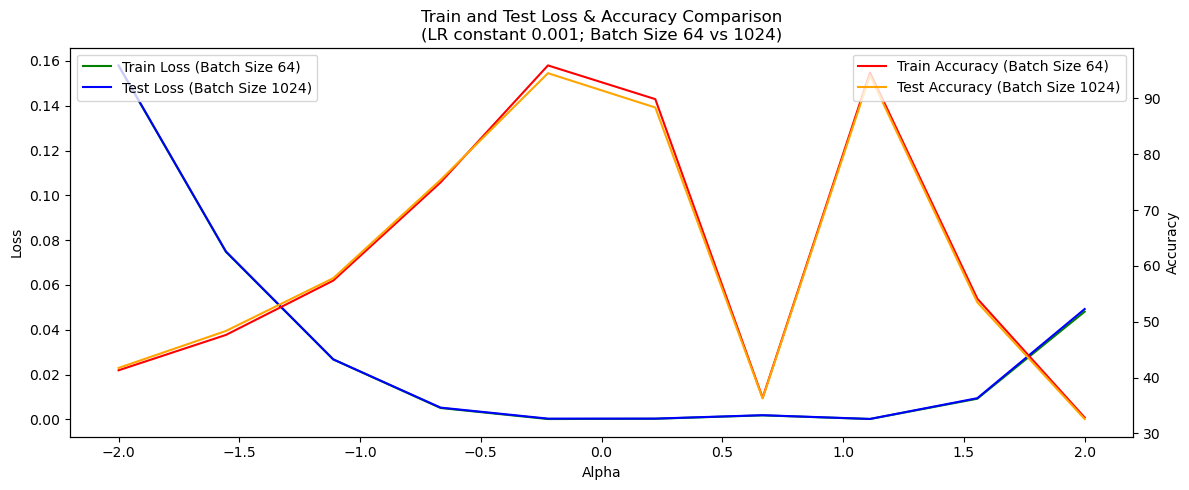

In [32]:
fig, ax1 = plt.subplots(figsize=(12, 5))

alphas = np.linspace(-2, 2, 10)

ax1.plot(alphas, train_loss_arr, color="green", label='Train Loss (Batch Size 64)')
ax1.plot(alphas, test_loss_arr, color="blue", label='Test Loss (Batch Size 1024)')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Loss', color='black')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()

ax2.plot(alphas, train_acc_arr, color="red", label='Train Accuracy (Batch Size 64)')
ax2.plot(alphas, test_acc_arr, color="orange", label='Test Accuracy (Batch Size 1024)')
ax2.set_ylabel('Accuracy', color='black')
ax2.set_title('Train and Test Loss & Accuracy Comparison\n(LR constant 0.001; Batch Size 64 vs 1024)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [33]:
model_state

{'model_bs_64_lr_0.001': Model(
   (fc1): Linear(in_features=784, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=16, bias=True)
   (fc3): Linear(in_features=16, out_features=10, bias=True)
 ),
 'model_bs_64_lr_0.01': Model(
   (fc1): Linear(in_features=784, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=16, bias=True)
   (fc3): Linear(in_features=16, out_features=10, bias=True)
 ),
 'model_bs_1024_lr_0.001': Model(
   (fc1): Linear(in_features=784, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=16, bias=True)
   (fc3): Linear(in_features=16, out_features=10, bias=True)
 ),
 'model_bs_1024_lr_0.01': Model(
   (fc1): Linear(in_features=784, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=16, bias=True)
   (fc3): Linear(in_features=16, out_features=10, bias=True)
 )}

In [34]:
# Prepare data loaders for batch sizes 64 and 1024
train_loader_64, test_loader_64 = dataset_prep(64)
train_loader_1024, test_loader_1024 = dataset_prep(1024)

# Perform interpolation between models with learning rate 0.01 for different batch sizes
train_loss_arr, train_acc_arr, test_loss_arr, test_acc_arr = interpolation(
    model_state["model_bs_64_lr_0.01"],
    model_state["model_bs_1024_lr_0.01"],
    train_loader_1024,
    test_loader_1024
)


Interpolation step 0 with alpha -2.00
Interpolation step 1 with alpha -1.56
Interpolation step 2 with alpha -1.11
Interpolation step 3 with alpha -0.67
Interpolation step 4 with alpha -0.22
Interpolation step 5 with alpha 0.22
Interpolation step 6 with alpha 0.67
Interpolation step 7 with alpha 1.11
Interpolation step 8 with alpha 1.56
Interpolation step 9 with alpha 2.00


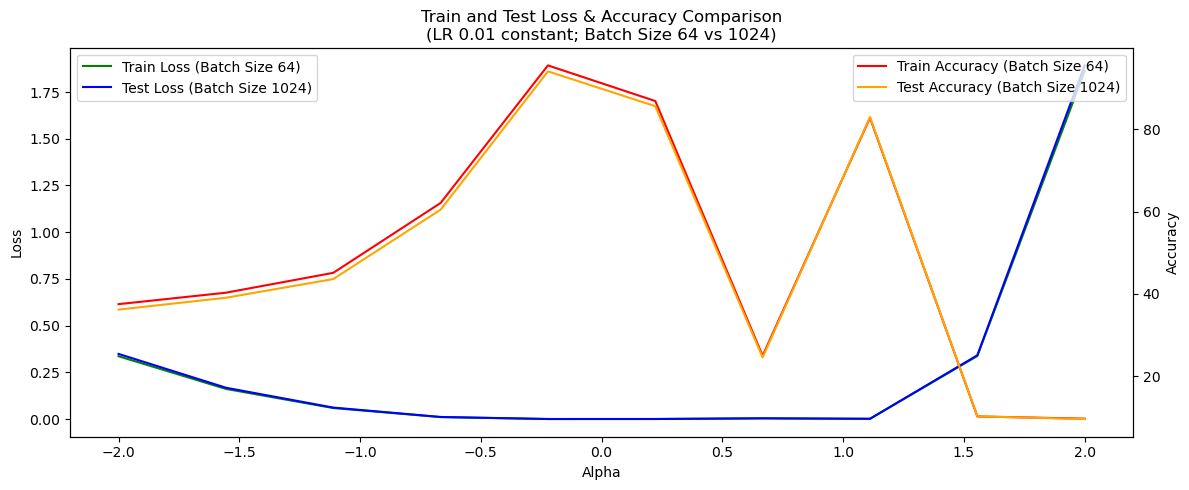

In [35]:
fig, ax1 = plt.subplots(figsize=(12, 5))

alphas = np.linspace(-2, 2, 10)

ax1.plot(alphas, train_loss_arr, color="green", label='Train Loss (Batch Size 64)')
ax1.plot(alphas, test_loss_arr, color="blue", label='Test Loss (Batch Size 1024)')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Loss', color='black')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()

ax2.plot(alphas, train_acc_arr, color="red", label='Train Accuracy (Batch Size 64)')
ax2.plot(alphas, test_acc_arr, color="orange", label='Test Accuracy (Batch Size 1024)')
ax2.set_ylabel('Accuracy', color='black')

ax2.set_title('Train and Test Loss & Accuracy Comparison\n(LR 0.01 constant; Batch Size 64 vs 1024)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()